## 💔 Heart Disease Prediction

Given *medical patient data*, let's try to predict if a given patient will have **heart disease**.

We will use logistic regression, support vector machine, and neural network models to make our predictions.

Data source: https://www.kaggle.com/datasets/thisishusseinali/uci-heart-disease-data

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [6]:
data = pd.read_csv('heart_disease_data.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48,1,0,130,256,1,0,150,1,0.0,2,2,3,0
1,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
2,44,0,2,118,242,0,1,149,0,0.3,1,1,2,1
3,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
4,56,1,3,120,193,0,0,162,0,1.9,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,60,1,2,140,185,0,0,155,0,3.0,1,0,2,0
602,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1
603,40,1,3,140,199,0,1,178,1,1.4,2,0,3,1
604,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       606 non-null    int64  
 1   sex       606 non-null    int64  
 2   cp        606 non-null    int64  
 3   trestbps  606 non-null    int64  
 4   chol      606 non-null    int64  
 5   fbs       606 non-null    int64  
 6   restecg   606 non-null    int64  
 7   thalach   606 non-null    int64  
 8   exang     606 non-null    int64  
 9   oldpeak   606 non-null    float64
 10  slope     606 non-null    int64  
 11  ca        606 non-null    int64  
 12  thal      606 non-null    int64  
 13  target    606 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 66.4 KB


### Exploratory Data Analysis

Let's get some box plots for each numeric variable and a correlation heatmap for the dataset.

In [14]:
numeric_features = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']

eda_df = data.loc[:, numeric_features].copy()

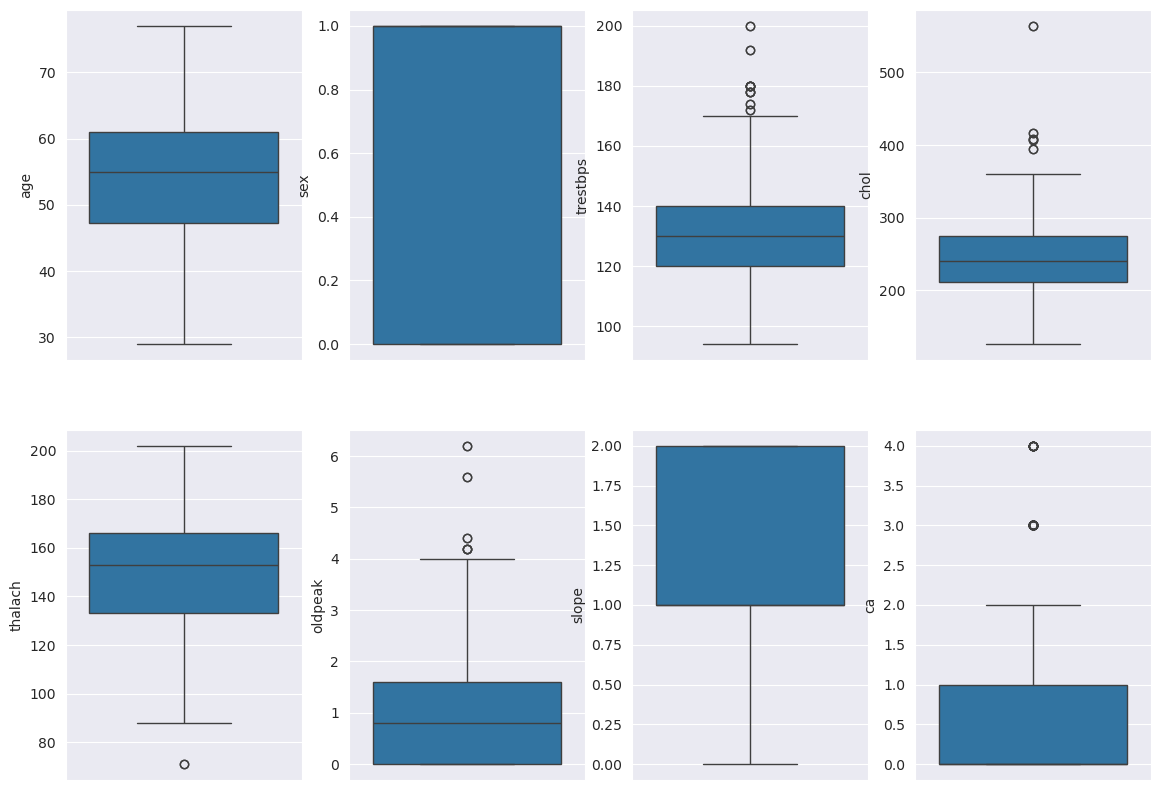

In [16]:
plt.figure(figsize=(14, 10))
for i in range(len(eda_df.columns)):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(eda_df[eda_df.columns[i]])
plt.show()

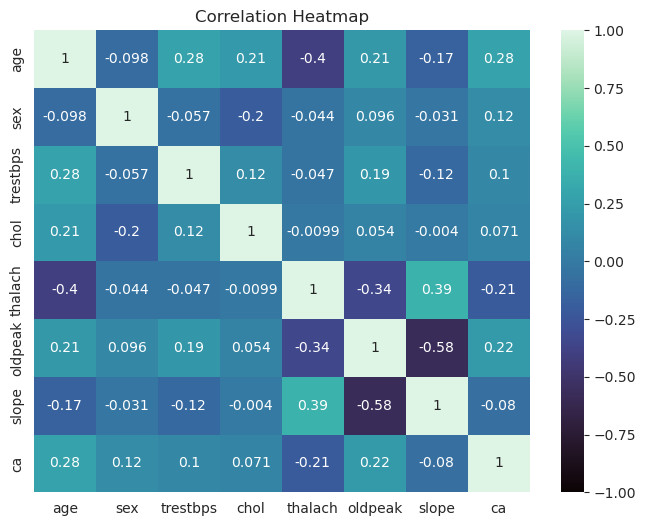

In [19]:
corr = eda_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show()

We can also visualize the class distribution with a pie chart.

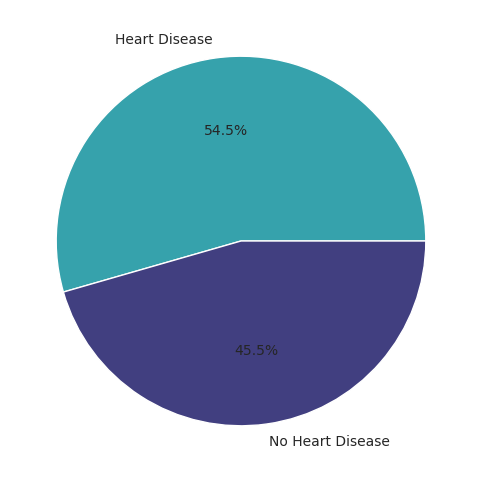

In [22]:
plt.figure(figsize=(6, 6))
plt.pie(data['target'].value_counts(), labels=['Heart Disease', 'No Heart Disease'], autopct='%.1f%%', colors=['#36a2ac', '#413f80'])
plt.title("Class Distribution")
plt.show()

### Preprocessing

In [8]:
df = data.copy()

In [12]:
{column: df[column].unique() for column in df.columns}

{'age': array([48, 61, 44, 47, 56, 68, 63, 35, 66, 41, 69, 57, 58, 37, 52, 60, 62,
        59, 46, 39, 40, 65, 70, 43, 45, 54, 49, 74, 38, 64, 51, 55, 50, 53,
        67, 34, 29, 77, 42, 76, 71]),
 'sex': array([1, 0]),
 'cp': array([0, 2, 3, 1]),
 'trestbps': array([130, 148, 118, 110, 120, 144, 126, 108, 160, 128, 105, 140, 150,
        170, 142, 152,  94, 122, 180, 135, 124, 125, 138, 146, 112, 155,
        100, 154, 145, 172, 134, 165, 200, 178, 114, 136, 132, 115, 106,
        101, 156, 164, 174, 117, 104, 129, 192, 102, 123]),
 'chol': array([256, 203, 242, 275, 193, 254, 282, 302, 269, 204, 234, 303, 240,
        215, 192, 233, 335, 268, 288, 177, 325, 267, 298, 199, 223, 417,
        213, 394, 243, 354, 274, 284, 239, 270, 253, 259, 264, 286, 167,
        246, 273, 175, 263, 211, 197, 308, 278, 205, 160, 212, 290, 198,
        149, 244, 232, 257, 219, 174, 231, 218, 245, 313, 201, 206, 315,
        330, 186, 182, 266, 222, 294, 289, 226, 304, 157, 230, 227, 309,
        208, 23

In [23]:
# One-hot encode nominal features
nominal_features = ['cp', 'slope', 'thal']

In [24]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [29]:
dict(zip(nominal_features, ['CP', 'SL', 'TH']))

{'cp': 'CP', 'slope': 'SL', 'thal': 'TH'}

In [30]:
df = onehot_encode(df, dict(zip(nominal_features, ['CP', 'SL', 'TH'])))
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,CP_1,CP_2,CP_3,SL_0,SL_1,SL_2,TH_0,TH_1,TH_2,TH_3
0,48,1,130,256,1,0,150,1,0.0,2,...,False,False,False,False,False,True,False,False,False,True
1,61,1,148,203,0,1,161,0,0.0,1,...,False,False,False,False,False,True,False,False,False,True
2,44,0,118,242,0,1,149,0,0.3,1,...,False,True,False,False,True,False,False,False,True,False
3,47,1,110,275,0,0,118,1,1.0,1,...,False,False,False,False,True,False,False,False,True,False
4,56,1,120,193,0,0,162,0,1.9,0,...,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,60,1,140,185,0,0,155,0,3.0,0,...,False,True,False,False,True,False,False,False,True,False
602,67,0,115,564,0,0,160,0,1.6,0,...,False,True,False,False,True,False,False,False,False,True
603,40,1,140,199,0,1,178,1,1.4,0,...,False,False,True,False,False,True,False,False,False,True
604,50,0,110,254,0,0,159,0,0.0,0,...,False,False,False,False,False,True,False,False,True,False


In [31]:
# Split df into X and y
X = df.drop('target', axis= 1)
y = df['target']

### Training 

#### Scaling (Standard, Robust and MinMax)

In [32]:
# Scale X (StandardScaler)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,CP_1,CP_2,CP_3,SL_0,SL_1,SL_2,TH_0,TH_1,TH_2,TH_3
0,-0.702136,0.681005,-0.092738,0.188152,2.394438,-1.005832,0.015443,1.435481,-0.896862,1.244593,...,-0.444554,-0.634648,-0.286606,-0.272888,-0.926766,1.064802,-0.081514,-0.251312,-1.100763,1.260850
1,0.731619,0.681005,0.935294,-0.836098,-0.417635,0.898962,0.496478,-0.696631,-0.896862,0.265082,...,-0.444554,-0.634648,-0.286606,-0.272888,-0.926766,1.064802,-0.081514,-0.251312,-1.100763,1.260850
2,-1.143291,-1.468418,-0.778093,-0.082404,-0.417635,0.898962,-0.028288,-0.696631,-0.638053,0.265082,...,-0.444554,1.575677,-0.286606,-0.272888,1.079021,-0.939142,-0.081514,-0.251312,0.908461,-0.793116
3,-0.812425,0.681005,-1.234996,0.555337,-0.417635,-1.005832,-1.383933,1.435481,-0.034166,0.265082,...,-0.444554,-0.634648,-0.286606,-0.272888,1.079021,-0.939142,-0.081514,-0.251312,0.908461,-0.793116
4,0.180175,0.681005,-0.663867,-1.029353,-0.417635,-1.005832,0.540209,-0.696631,0.742260,-0.714429,...,-0.444554,-0.634648,3.489114,-0.272888,1.079021,-0.939142,-0.081514,-0.251312,-1.100763,1.260850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,0.621330,0.681005,0.478391,-1.183957,-0.417635,-1.005832,0.234095,-0.696631,1.691225,-0.714429,...,-0.444554,1.575677,-0.286606,-0.272888,1.079021,-0.939142,-0.081514,-0.251312,0.908461,-0.793116
602,1.393352,-1.468418,-0.949431,6.140401,-0.417635,-1.005832,0.452748,-0.696631,0.483451,-0.714429,...,-0.444554,1.575677,-0.286606,-0.272888,1.079021,-0.939142,-0.081514,-0.251312,-1.100763,1.260850
603,-1.584446,0.681005,0.478391,-0.913400,-0.417635,0.898962,1.239897,1.435481,0.310912,-0.714429,...,-0.444554,-0.634648,3.489114,-0.272888,-0.926766,1.064802,-0.081514,-0.251312,-1.100763,1.260850
604,-0.481558,-1.468418,-1.234996,0.149501,-0.417635,-1.005832,0.409017,-0.696631,-0.896862,-0.714429,...,-0.444554,-0.634648,-0.286606,-0.272888,-0.926766,1.064802,-0.081514,-0.251312,0.908461,-0.793116


In [33]:
y

0      0
1      0
2      1
3      0
4      1
      ..
601    0
602    1
603    1
604    1
605    0
Name: target, Length: 606, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [39]:
lr_model = LogisticRegression()
svm_model = SVC()
nn_model = MLPClassifier()

In [40]:
lr_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)

/home/aditya/miniconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [42]:
print("Logistic Regression Accuracy: {:.2f}%".format(lr_model.score(X_test, y_test)*100))

Logistic Regression Accuracy: 84.43%


In [44]:
print("Support Vector Machine Accuracy: {:.2f}%".format(svm_model.score(X_test, y_test)*100))

Support Vector Machine Accuracy: 87.70%


In [46]:
print("Neural Network Accuracy: {:.2f}%".format(nn_model.score(X_test, y_test)*100))

Neural Network Accuracy: 91.80%


In [47]:
# RobustScaler
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
lr_model = LogisticRegression()
svm_model = SVC()
nn_model = MLPClassifier()
lr_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
print("Logistic Regression Accuracy: {:.2f}%".format(lr_model.score(X_test, y_test)*100))
print("Support Vector Machine Accuracy: {:.2f}%".format(svm_model.score(X_test, y_test)*100))
print("Neural Network Accuracy: {:.2f}%".format(nn_model.score(X_test, y_test)*100))

Logistic Regression Accuracy: 84.43%
Support Vector Machine Accuracy: 86.07%
Neural Network Accuracy: 94.26%


/home/aditya/miniconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
# MinMaxScaler
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
lr_model = LogisticRegression()
svm_model = SVC()
nn_model = MLPClassifier()
lr_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
print("Logistic Regression Accuracy: {:.2f}%".format(lr_model.score(X_test, y_test)*100))
print("Support Vector Machine Accuracy: {:.2f}%".format(svm_model.score(X_test, y_test)*100))
print("Neural Network Accuracy: {:.2f}%".format(nn_model.score(X_test, y_test)*100))

Logistic Regression Accuracy: 84.43%
Support Vector Machine Accuracy: 85.25%
Neural Network Accuracy: 86.07%


/home/aditya/miniconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
